# Template for emotion analysis

- This serves the purpose of correctly identifying the two politicians throughout each frame of a given debate and correctly matching the corresponding identified emotion.

- The bounding box coordinates approach will be used for frames where the two politicians are in frame.

- When only one politician is in frame, facial embedding vectors will be used and clustered. However, if the result of the clustering approaches is not reasonable enough, those frames will be discarded for the analysis (which correspond to moreless 40% of the debate)


## Instructions:
1. Download debate frames folder (not processed) and include it in __.gitignore file__!
2. Check if the video has sign language interpreter or not. If not readjust 4, 3 and 2 'people on frame' if conditions to 3, 2 and 1.
3. Follow the numbered instructions throughout the code. 


In [10]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mtick
from PIL import Image
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA


###########################################
##########  0. SELECT THE DEBATE ##########

data = pd.read_pickle("../../pkl_files/pan-ps.pkl")
###########################################


# Order the frames by name
data = data.sort_values(by='filename')

In [11]:
# Initialize an empty list to store all embedding vectors
embedding_list = []


########################################
##########  1. SELECT THE PEOPLE #######

# Each list will store the fer of each person in the frame
# and the corresponding frame number

Politician_1 = [] # Left side of the screen
Politician_2 = [] # Right side of the screen
#TV_Host = []
#Sign_Language_Interpreter = []
########################################


# Collect all facial embedding vectors from the 'fer' column of each frame
for i in range(data.shape[0]):

    # Debate starts at frame 60 (minute 1)
    if i >= 60:

        # 4 people on frame
        if len(data.iloc[i]['fer']) == 4: 

            # Initialize a empty list to store each person in the frame
            people = []

            # Iterate through each face in the frame 
            for fer in data.iloc[i]['fer']:
                people.append(fer)

            # Sort the people by the x-coordinate of the bounding box
            people = sorted(people, key=lambda x: x['location'][0])

            # Append the fer of each person to the corresponding list
            Politician_1.append((people[0], i))
            # TV_Host.append(people[1], i) -- not needed
            Politician_2.append((people[2], i))
            # Sign_Language_Interpreter.append(people[3], i) -- not needed


        # 3 people on frame
        elif len(data.iloc[i]['fer']) == 3:

            # Initialize a empty list to store each person in the frame
            people = []

            # Iterate through each face in the frame 
            for fer in data.iloc[i]['fer']:
                people.append(fer)

            # Sort the people by the x-coordinate of the bounding box
            people = sorted(people, key=lambda x: x['location'][0])

            # Append the fer of each person to the corresponding list
            Politician_1.append((people[0], i))
            Politician_2.append((people[1], i))
            # Sign_Language_Interpreter.append(people[2], i) -- not needed


        # 2 people on frame (one is the sign language interpreter)
        elif len(data.iloc[i]['fer']) == 2:
            # Initialize a empty list to store each person in the frame
            people = []

            # Iterate through each face in the frame 
            for fer in data.iloc[i]['fer']:
                people.append(fer)

            # Sort the people by the x-coordinate of the bounding box
            people = sorted(people, key=lambda x: x['location'][0])

            # Append the fer of each person to the corresponding list
            embedding_list.append(people[0]['embedding'])
            # Sign_Language_Interpreter.append(people[1], i) -- not needed



# Notes:

- Now we have successfully applied the bounding box method.

- We've also stored the embeddings for 2 faces frames (or one face frames if there isn't sign language interpreter). Now we have to cluster them. 

- Obviously there will be frames where the person that appears is the TV host and not one of the politicians. But the ratio is really small. We can also use 3 cluster instead of 2.

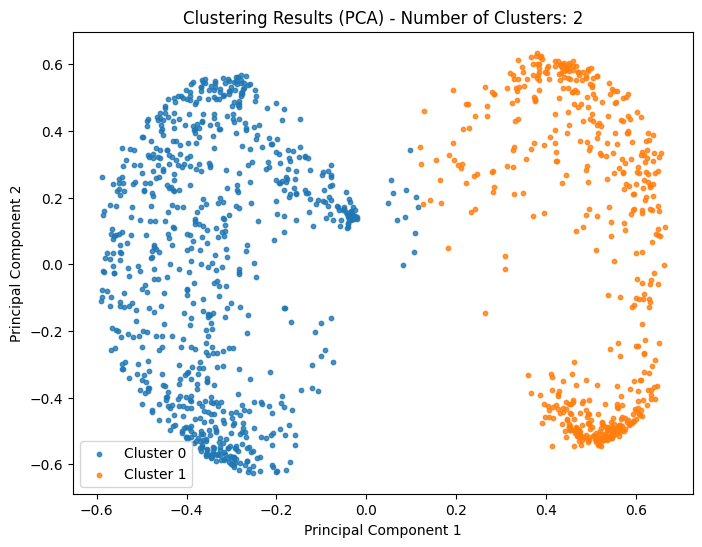

In [12]:
# Convert the list of embeddings into a NumPy array
embedding_array = np.array(embedding_list)

########################################
##########  2. CLUSTERING METHODS ######
num_clusters = 2

# Apply K-means clustering or Spectral clustering (see the best method for your data)
#kmeans = KMeans(n_clusters=num_clusters)
#cluster_labels = kmeans.fit_predict(embedding_array)

spectral = SpectralClustering(n_clusters=num_clusters)
cluster_labels = spectral.fit_predict(embedding_array)
########################################


# Reduce the dimensionality of the embedding vectors using PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
embedding_pca = pca.fit_transform(embedding_array)

# Plot clusters in 2D space after PCA
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(embedding_pca[cluster_labels == i, 0], embedding_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=1-num_clusters*0.1, s=10)
plt.title('Clustering Results (PCA) - Number of Clusters: ' + str(num_clusters))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show() 

# Person 0


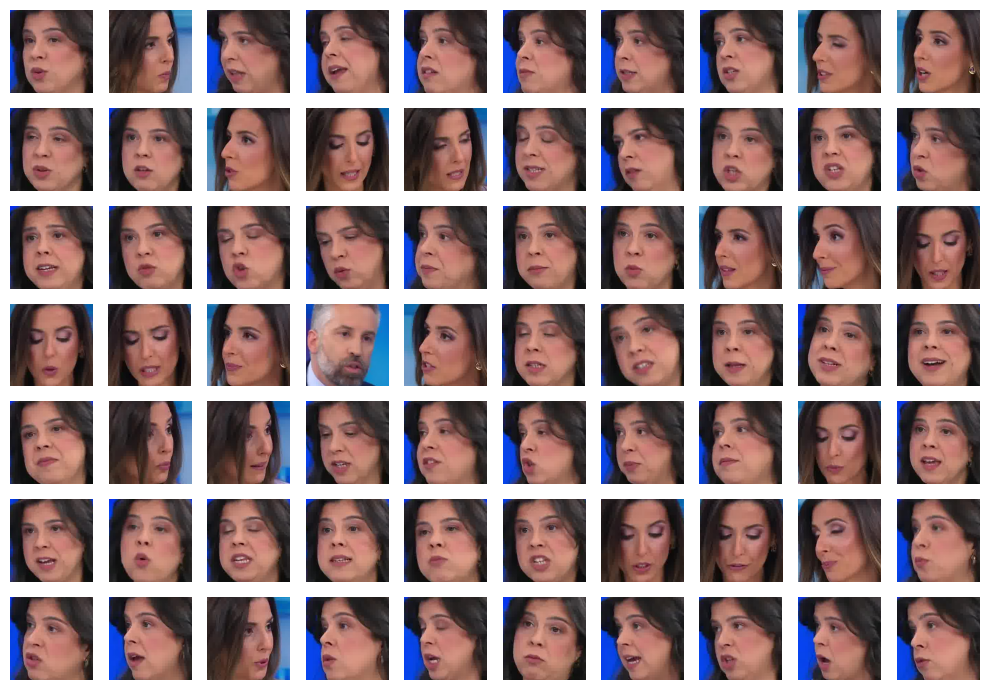

# Person 1


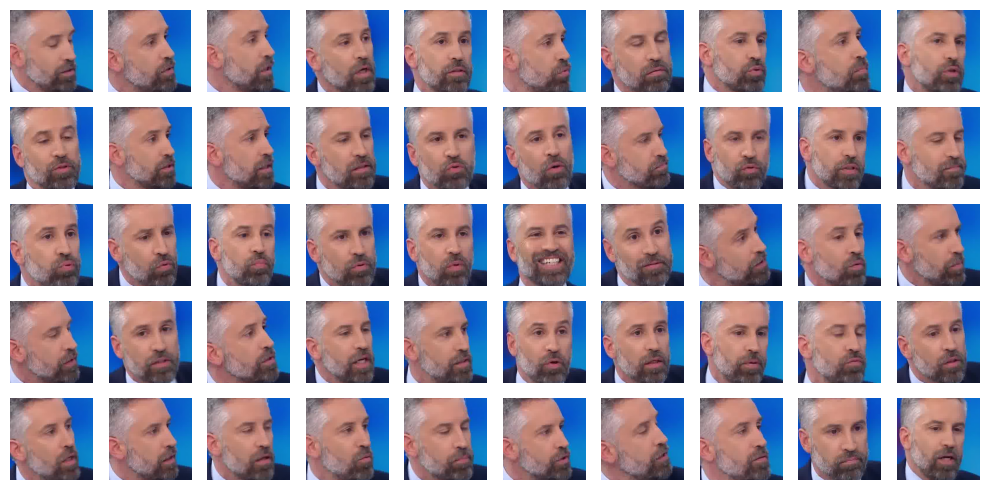

In [13]:
# Create a dictionary to match cluster number to person name
cluster_to_person = {
    0: 'Person 0',
    1: 'Person 1'
}

# Create a dictionary to store the faces for each person
faces_by_person = {person: [] for person in cluster_to_person.values()}

# Iterate through each frame in the dataset
for i in range(data.shape[0]):
    # Decide which frames to plot (one frame every 10 frames)
    if i % 10 == 0 and i >= 60:

        # Only consider 2 faces frames
        if len(data.iloc[i]['fer']) == 2:

            # Iterate through each face in the frame
            for fer in data.iloc[i]['fer']:
                # Look for embedding vector of the face in embedding_array
                embedding = fer['embedding']
                indices = np.where((embedding_array == embedding).all(axis=1))[0]

                # Check if indices is not empty
                if indices.size > 0:
                    embedding_index = indices[0]
                else:
                    continue  # Skip to the next iteration if indices is empty

                # Look for cluster number of the face in cluster_labels
                cluster_number = cluster_labels[embedding_index]

                # Look for person name of the cluster number in cluster_to_person
                person_name = cluster_to_person[cluster_number]

                # Add the filename to the face dictionary
                fer['filename'] = data.iloc[i]['filename']

                # Add the face to the corresponding person's list
                faces_by_person[person_name].append(fer)

# Create lists to store the cropped images of each face
cropped_images = []

# Iterate through each person
for person_name, faces in faces_by_person.items():
    print(f"# {person_name}")

    # Iterate through each face
    for fer in faces:
        ########################################
        ##########  3. PLOT THE FACES ##########

        # Plot frame image from the right folder!
        img = Image.open(os.path.join('../../debates/pan-ps/', fer['filename']))
        ########################################

        # Extract the bounding box coordinates
        x = fer['location'][0]
        y = fer['location'][2]
        width = fer['location'][1] - fer['location'][0]
        height = fer['location'][3] - fer['location'][2]

        # Crop the image to the bounding box
        cropped_img = img.crop((x, y, x + width, y + height))

        # Add the cropped image to the list
        cropped_images.append(cropped_img)

    # Determine the number of images and the number of images per row
    num_images = len(cropped_images)
    images_per_row = 10  # Adjust as needed

    # Adjust the number of images to be a multiple of images_per_row
    num_images = (num_images // images_per_row) * images_per_row

    # Determine the number of rows
    num_rows = num_images // images_per_row

    # Create a figure with a subplot for each image
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(images_per_row, num_rows))  # Adjust size as needed

    # Iterate through each image
    for i, cropped_img in enumerate(cropped_images[:num_images]):
        # Determine the row and column indices of the subplot
        row = i // images_per_row
        col = i % images_per_row

        # Display the cropped image in the corresponding subplot
        axs[row, col].imshow(cropped_img)
        axs[row, col].axis('off')  # Hide axes

    # Display all images
    plt.tight_layout()
    plt.show()

    # Clear the list of cropped images for the next person
    cropped_images.clear()

# Decision time
Now we have to decide if the clustering was good enough and use these frames for emotion vs time analysis or if we simply discard them.
So run or not the following code section

In [14]:
########################################
##########  4. INCLUDE CLUSTERING? #####

# Run this code only if you want to use 2 face frames (clustering is good enough)
########################################

# Create a dictionary to map embeddings to their cluster labels
embedding_to_label = {tuple(embedding): label for embedding, label in zip(embedding_array, cluster_labels)}

# Create a dictionary to map cluster labels to person names
label_to_person = {label: person for person, label in cluster_to_person.items()}

# Iterate through each frame in the dataset
for i in range(data.shape[0]):
    for fer in data.iloc[i]['fer']:
        # Look for the cluster label of the face's embedding
        embedding = tuple(fer['embedding'])
        if embedding in embedding_to_label:
            cluster_label = embedding_to_label[embedding]

            # Look for the person name of the cluster label
            if cluster_label in label_to_person:
                person_name = label_to_person[cluster_label]

                ################################################
                ###### 5. ADD THE FACE TO THE RIGHT LIST #######
                # Add the face to the appropriate list
                if person_name == 'Person 0':
                    Politician_2.append((fer, i))
                elif person_name == 'Person 1':
                    Politician_1.append((fer, i))

                ################################################


# Status:
Now we have every politician list filled with its corresponding fer's. Let's order them by frame number in order to correctly evaluate their emotions through time.

In [15]:
# Order Politician_1 and Politician_2 by frame number
Politician_1 = sorted(Politician_1, key=lambda x: x[1])
Politician_2 = sorted(Politician_2, key=lambda x: x[1])



# Final step: emotion analysis

Now we have all the fer's divided by politician and in chronological order!

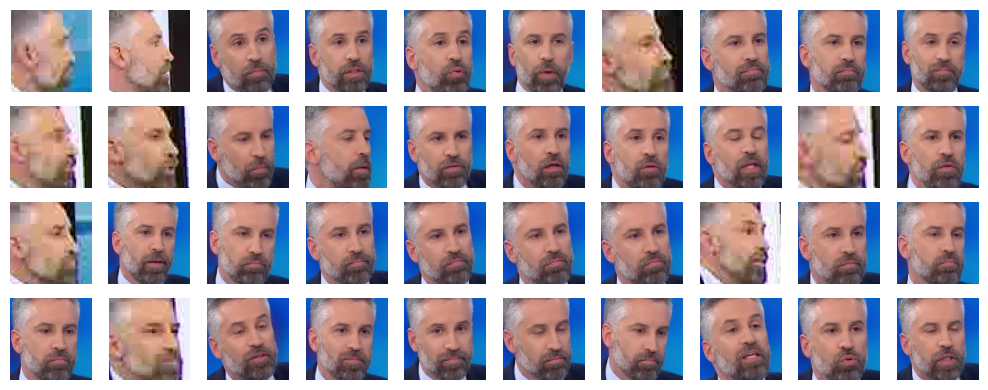

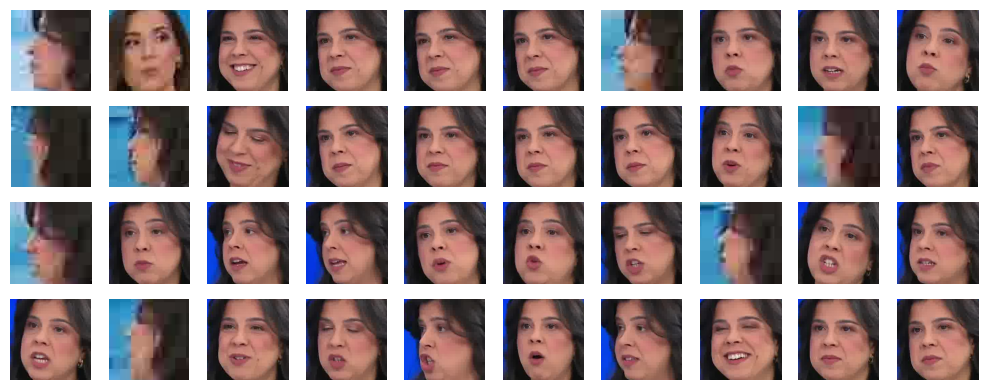

In [16]:
# Plot the faces of Politician_1 and Politician_2 (just to check if people identified are correct)

# Create list of images
cropped_images = []

# Iterarte over dataset and check the fer's of each frame
# If the fer is in Politician_1 or Politician_2, open the image and plot the face
for i in range(data.shape[0]):
    if i % 10 == 0 and i >= 60:
        img = Image.open(os.path.join('../../debates/pan-ps/', data.iloc[i]['filename']))
        for fer in data.iloc[i]['fer']:
            if fer in [x[0] for x in Politician_1]:
                x = fer['location'][0]
                y = fer['location'][2]
                width = fer['location'][1] - fer['location'][0]
                height = fer['location'][3] - fer['location'][2]
                cropped_img = img.crop((x, y, x + width, y + height))
                # Add the cropped image to the list
                cropped_images.append(cropped_img)

# Determine the number of images and the number of images per row
num_images = len(cropped_images)
images_per_row = 10  # Adjust as needed

# Adjust the number of images to be a multiple of images_per_row
num_images = (num_images // images_per_row) * images_per_row

# Determine the number of rows
num_rows = num_images // images_per_row

# Create a figure with a subplot for each image
fig, axs = plt.subplots(num_rows, images_per_row, figsize=(images_per_row, num_rows))  # Adjust size as needed

# Iterate through each image
for i, cropped_img in enumerate(cropped_images[:num_images]):
    # Determine the row and column indices of the subplot
    row = i // images_per_row
    col = i % images_per_row

    # Display the cropped image in the corresponding subplot
    axs[row, col].imshow(cropped_img)
    axs[row, col].axis('off')  # Hide axes

# Display all images
plt.tight_layout()
plt.show()

# Clear the list of cropped images for the next person
cropped_images.clear()
            
for i in range(data.shape[0]):
    if i % 10 == 0 and i >= 60:
        img = Image.open(os.path.join('../../debates/pan-ps/', data.iloc[i]['filename']))
        for fer in data.iloc[i]['fer']:
            if fer in [x[0] for x in Politician_2]:
                x = fer['location'][0]
                y = fer['location'][2]
                width = fer['location'][1] - fer['location'][0]
                height = fer['location'][3] - fer['location'][2]
                cropped_img = img.crop((x, y, x + width, y + height))
                # Add the cropped image to the list
                cropped_images.append(cropped_img)

# Determine the number of images and the number of images per row
num_images = len(cropped_images)

# Adjust the number of images to be a multiple of images_per_row
num_images = (num_images // images_per_row) * images_per_row

# Determine the number of rows
num_rows = num_images // images_per_row

# Create a figure with a subplot for each image
fig, axs = plt.subplots(num_rows, images_per_row, figsize=(images_per_row, num_rows))  # Adjust size as needed

# Iterate through each image
for i, cropped_img in enumerate(cropped_images[:num_images]):
    # Determine the row and column indices of the subplot
    row = i // images_per_row
    col = i % images_per_row

    # Display the cropped image in the corresponding subplot
    axs[row, col].imshow(cropped_img)
    axs[row, col].axis('off')  # Hide axes

# Display all images
plt.tight_layout()
plt.show()

# Function to count emotions and give a score

1. Consider the count of each emotion for a politician. We can calculate their emotional score using the following formula:

Emotional Score=(4xNeutral Count)+(5×Happiness Count)+(3×Surprise Count)−(2×Anger Count)−(2×Fear Count)−(2×Contempt Count)−(1×Sadness Count)−(2×Disgust Count)


2. Then we divide this value by total number of identified emotions of the given politician in the debate: average emotion score for the debate.

3. This value is the main goal of this script. We will use it in another one to sum and compute the total score of the politician.


In [17]:

def count_emotions(array_emotions):
    # Extract only the dictionaries
    politician_data_ilbe_MM = [data_point[0] for data_point in array_emotions]


    # List of all possible emotions
    emotions = ['Anger', 'Surprise', 'Fear', 'Contempt', 'Neutral', 'Sadness', 'Disgust', 'Happiness']

    # Initialize a dictionary to hold the counts of each emotion
    emotion_counts = {emotion: 0 for emotion in emotions}

    # Loop through the data and count each emotion
    for data_point in politician_data_ilbe_MM:
        emotion = data_point['emotion']
        if emotion in emotion_counts:
            emotion_counts[emotion] += 1

    return emotion_counts

def calculate_emotional_score(emotion_counts, length):
    # Define the weights for each emotion
    weights = {
        'Happiness': 5,
        'Surprise': 3,
        'Anger': -2,
        'Fear': -2,
        'Contempt': -2,
        'Sadness': -1,
        'Disgust': -2,
        'Neutral': 4
    }
    
    # Calculate the emotional score
    score = sum(weights[emotion] * count for emotion, count in emotion_counts.items())
    
    return score/length




# Final score

- Now we print the count of emotions of each politician and give the right score.

In [18]:
# Print the emotions of each person and their emotional score
print("PNS emotions: ", count_emotions(Politician_1))
print("Ines Sousa Real emotions: ", count_emotions(Politician_2))

# Compute the emotional score for each person
print("\nPNS emotional score: ", calculate_emotional_score(count_emotions(Politician_1), len(Politician_1)))
print("Ines Sousa Real emotional score: ", calculate_emotional_score(count_emotions(Politician_2), len(Politician_2)))

PNS emotions:  {'Anger': 2, 'Surprise': 58, 'Fear': 3, 'Contempt': 0, 'Neutral': 327, 'Sadness': 26, 'Disgust': 18, 'Happiness': 1}
Ines Sousa Real emotions:  {'Anger': 0, 'Surprise': 156, 'Fear': 5, 'Contempt': 14, 'Neutral': 116, 'Sadness': 9, 'Disgust': 115, 'Happiness': 20}

PNS emotional score:  3.2528735632183907
Ines Sousa Real emotional score:  1.735632183908046
